In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,MaxPool2D,BatchNormalization,Dropout,Flatten,Activation,GlobalAveragePooling2D
from PIL import Image
import tensorflow as tf
tf.keras.applications.VGG16
from keras.applications.vgg16 import VGG16
from pathlib import Path

In [ ]:
os.listdir('/kaggle/input/corn-or-maize-leaf-disease-dataset/data')

In [3]:
import matplotlib.pyplot as plt
from matplotlib import image
from PIL import Image

In [4]:
def load_imgs(impath):
    imgs=[]
    label=[]
    l1=os.listdir(impath)
    for i in l1:
        c=0
        l2=os.listdir(impath+'/'+i)
        for j in l2:
            if c<=1000:
                img = Image.open(impath+'/'+i+'/'+j)
                img = img.resize((224,224))
                img = np.array(img)
                if(img.shape == (224,224,3)):
                    imgs.append(img)
                    label.append(i)
                del img
                c=c+1
    return np.array(imgs),label

In [5]:
x,y=load_imgs('/kaggle/input/corn-or-maize-leaf-disease-dataset/data/')
x.shape,len(y)

((3572, 224, 224, 3), 3572)

In [6]:
target=pd.Series(y,dtype='category')
target

0          Common_Rust
1          Common_Rust
2          Common_Rust
3          Common_Rust
4          Common_Rust
             ...      
3567    Gray_Leaf_Spot
3568    Gray_Leaf_Spot
3569    Gray_Leaf_Spot
3570    Gray_Leaf_Spot
3571    Gray_Leaf_Spot
Length: 3572, dtype: category
Categories (4, object): ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [7]:
target.value_counts()

Blight            1001
Healthy           1001
Common_Rust        998
Gray_Leaf_Spot     572
dtype: int64

In [8]:
t=target.cat.codes
t

0       1
1       1
2       1
3       1
4       1
       ..
3567    2
3568    2
3569    2
3570    2
3571    2
Length: 3572, dtype: int8

In [9]:
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y=train_test_split(x,t,test_size=0.2,shuffle=True)
train_x.shape,test_x.shape,train_y.shape,test_y.shape

((2857, 224, 224, 3), (715, 224, 224, 3), (2857,), (715,))

In [10]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

In [11]:
from tensorflow.keras.layers import Lambda

In [12]:
def second_order_pooling(x):
    # Compute outer product
    outer_product = tf.matmul(tf.expand_dims(x, -1), tf.expand_dims(x, 1))
    # Flatten outer product
    pool_size = [2, 2]  # Size of the pooling window
    stride = [2, 2]   
    #flattened = tf.reshape(outer_product, (-1, tf.shape(x)[1]*tf.shape(x)[1]))
    reshaped_output = tf.expand_dims(outer_product, axis=-1)
    # Normalize the flattened tensor
    pooled_output = tf.nn.max_pool(reshaped_output, ksize=[1, pool_size[0], pool_size[1], 1], strides=[1, stride[0], stride[1], 1], padding='VALID')
    normalized = tf.math.l2_normalize(pooled_output, axis=1)
    
    return normalized

In [72]:
import tensorflow.keras as K
input_v = K.Input(shape=(224,224,3))
modelresnet = K.applications.ResNet50(include_top=False,weights='imagenet',input_tensor = input_v)

In [73]:
x = modelresnet.output

In [74]:
for layer in modelresnet.layers:
    layer.trainable = False

In [75]:
from tensorflow.keras.layers import MaxPooling2D

In [ ]:
num_classes = 4
for (i,layer) in enumerate(modelresnet.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)
    def lw(bottom_model,num_classes):
        global top_model
        global Globalavgpool
        global denselayer_512
        global x
        global denseoutput
        top_model = bottom_model.output
        Globalavgpool = GlobalAveragePooling2D()(top_model)
        #top_model = Dense(4096,activation='relu')(top_model)
#         top_model = Dropout(0.25, name='dropout_1')(top_model)
#         top_model = Dense(1024,activation='relu')(top_model)
        #top_model = Dense(512,activation='relu')(top_model)
        denselayer_512 = Dense(512,activation='relu')(Globalavgpool)
        x = Lambda(second_order_pooling)(denselayer_512) 
        #x = MaxPooling2D((3,3))(x)
        flatten = Flatten()(x)
        denseoutput = Dense(4,activation='softmax')(flatten)
        return denseoutput

In [89]:
num_classes = 4
FC_Head = lw(modelresnet , num_classes)
model = Model(inputs = modelresnet.input,outputs = FC_Head)

In [90]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [91]:
modelresnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [92]:
train_x.shape

(2857, 224, 224, 3)

In [93]:
train_y.shape

(2857,)

In [94]:
history = model.fit(train_x, train_y, epochs = 10, batch_size = 1, shuffle=True) 

Epoch 1/10
2857/2857 [==============================] - 37s 12ms/step - loss: 0.3395 - accuracy: 0.8708
Epoch 2/10
2857/2857 [==============================] - 33s 12ms/step - loss: 0.1845 - accuracy: 0.9237
Epoch 3/10
2857/2857 [==============================] - 33s 12ms/step - loss: 0.1462 - accuracy: 0.9412
Epoch 4/10
2857/2857 [==============================] - 34s 12ms/step - loss: 0.1061 - accuracy: 0.9569
Epoch 5/10
2857/2857 [==============================] - 33s 12ms/step - loss: 0.0905 - accuracy: 0.9639
Epoch 6/10
2857/2857 [==============================] - 33s 12ms/step - loss: 0.0666 - accuracy: 0.9748
Epoch 7/10
2857/2857 [==============================] - 33s 12ms/step - loss: 0.0440 - accuracy: 0.9842
Epoch 8/10
2857/2857 [==============================] - 34s 12ms/step - loss: 0.0436 - accuracy: 0.9839
Epoch 9/10
2857/2857 [==============================] - 34s 12ms/step - loss: 0.0388 - accuracy: 0.9856
Epoch 10/10
2857/2857 [==============================] - 34s 12m

In [95]:
for layer in model.layers:
    print(layer.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 230, 230, 3), dtype=tf.float32, name=None), name='conv1_pad/Pad:0', description="created by layer 'conv1_pad'")
KerasTensor(type_spec=TensorSpec(shape=(None, 112, 112, 64), dtype=tf.float32, name=None), name='conv1_conv/BiasAdd:0', description="created by layer 'conv1_conv'")
KerasTensor(type_spec=TensorSpec(shape=(None, 112, 112, 64), dtype=tf.float32, name=None), name='conv1_bn/FusedBatchNormV3:0', description="created by layer 'conv1_bn'")
KerasTensor(type_spec=TensorSpec(shape=(None, 112, 112, 64), dtype=tf.float32, name=None), name='conv1_relu/Relu:0', description="created by layer 'conv1_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 114, 114, 64), dtype=tf.float32, name=None), name='pool1_pad/Pad:0', description="created by layer 'pool1_pad'")
KerasTensor(type_spec=TensorSpec(

In [96]:
model.evaluate(test_x,test_y)

23/23 [==============================] - 3s 91ms/step - loss: 0.3826 - accuracy: 0.9133


[0.38259485363960266, 0.9132866859436035]

In [97]:
def names(number):
    if number==0:
        return "It's a leaf with disease BLIGHT"
    elif number==1:
        return "It's a leaf with disease Common Rust"
    elif number==2:
        return "It's a leaf with disease Gray_Leaf_Spot"
    elif number==3:
        return "It's a Healthy leaf"

In [98]:
from matplotlib.pyplot import imshow
def Prediction(img):
    #img = Image.open(r"../input/corn-or-maize-leaf-disease-dataset/data/Blight/Corn_Blight (1010).JPG")
    x = np.array(img.resize((224,224)))
    x = x.reshape(1,224,224,3)
    res = model.predict_on_batch(x)
    classification = np.where(res == np.amax(res))[1][0]
    imshow(img)
    print(str(res[0][classification]*100) + '% Confidence ' + names(classification))

100.0% Confidence It's a leaf with disease Common Rust


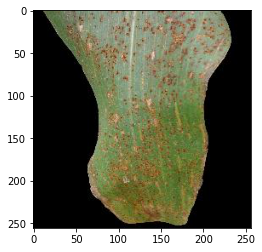

In [99]:
img = Image.open(r"/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/Corn_Common_Rust (1000).JPG")
Prediction(img)

In [100]:
x = np.array(img.resize((224,224)))
x = x.reshape(1,224,224,3)

In [101]:
print(x)

[[[[0 0 0]
   [0 0 0]
   [0 0 3]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 3]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 1 0]
   [0 0 0]
   [0 0 1]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  ...

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]]]


In [102]:
x

array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 3],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 3],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 1],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]]], dtype=uint8)

In [103]:
features = model.predict(x)

In [104]:
for i in range(features.shape[-1]):
    feature_map = features[0, i]
    print(f"Feature Map {i+1}:")
    print(feature_map)
    print()

Feature Map 1:
4.6804894e-13

Feature Map 2:
1.0

Feature Map 3:
1.0803064e-13

Feature Map 4:
3.0248633e-13



In [105]:
layer_outputs = [globalavgpool,denselayer_512,x]

NameError: name 'globalavgpool' is not defined

In [ ]:
for layer, feature_map in zip(layer_outputs, features):
    print(f"Layer: {layer.name}")
    print(f"Shape: {feature_map.shape}")
    print("Values:")
    print(feature_map)
    print()    

In [ ]:
print(features)

In [ ]:
matrix_values = features[0] 

In [ ]:
print(matrix_values)